# **Import dependencies**

In [1]:
import os

from bokeh.plotting import output_file, output_notebook, show, save
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from zipfile import ZipFile

from flasc.dataframe_operations import (
    dataframe_filtering as dff,
    dataframe_manipulations as dfm,
)
from flasc.turbine_analysis import ws_pow_filtering as wspf
from flasc.utilities_examples import load_floris_artificial as load_floris

In [2]:
# User settings
plot_figures = True  # Produce figures
save_figures = False  # Save the produced figures
use_bokeh_plotting_library = False  # New feature: use the Bokeh plotting library for interactive plots. Use with '%matplotlib widget' or with save_figures=True.

# Specify plotting option in your Jupyter Notebook. We recommend '%matplotlib widget' for
# interactive figures, allowing you to rescale, zoom in, etc. If this does not work, try
# '%matplotlib inline', which is the default and plots static figures.
# %matplotlib widget
%matplotlib inline

# **Step 0**: Initial data pulldown
First, we import the data from the common_windfarm_information folder. This may take a while, so we keep these variables unchanged. These are df_scada_raw and df_metmast_raw. These variables are not manipulated throughout the script.

In [3]:
def load_data():
    root_path = os.getcwd()
    source_path = os.path.join(root_path, "data")

    # Unzip .zip file and decompress raw data files (.csv)
    filename = os.path.join(source_path, "raw_artificial_data.zip")
    with ZipFile(filename) as zipfile:
        zipfile.extractall("data")

    df_scada_raw = pd.read_csv(
        os.path.join(source_path, "demo_dataset_scada_600s.csv")
    )
    df_metmast_raw = pd.read_csv(
        os.path.join(source_path, "demo_dataset_metmast_600s.csv")
    )

    return df_scada_raw, df_metmast_raw

df_scada_raw, df_metmast_raw = load_data()
print("Columns available in df_scada_raw: {}.".format(list(df_scada_raw.columns)))

Columns available in df_scada_raw: ['wd_truth', 'ws_truth', 'ti_truth', 'time', 'pow_000', 'pow_001', 'pow_002', 'pow_003', 'pow_004', 'pow_005', 'pow_006', 'ws_000', 'ws_001', 'ws_002', 'ws_003', 'ws_004', 'ws_005', 'ws_006', 'wd_000', 'wd_001', 'wd_002', 'wd_003', 'wd_004', 'wd_005', 'wd_006', 'ti_000', 'ti_001', 'ti_002', 'ti_003', 'ti_004', 'ti_005', 'ti_006', 'is_operation_normal_000', 'is_operation_normal_001', 'is_operation_normal_002', 'is_operation_normal_003', 'is_operation_normal_004', 'is_operation_normal_005', 'is_operation_normal_006'].


# **Step 1**: Format to common FLASC format
Format df_scada to pour the dataframe into the common FLASC format. For example, wind speeds are columns denoted by ws_{ti}, with {ti} the turbine number with prevailing zeros. Hence, for wind speed for the third turbine is defined by ws_002, and the power production of the thirteenth turbine is defined by pow_012.

In [4]:
def format_dataframes(df_scada, df_metmast):
    # Format columns and data. The operations required differ per dataset.
    df_scada["time"] = pd.to_datetime(df_scada["time"])  # Convert strings to timestamps
    df_metmast["time"] = pd.to_datetime(df_metmast["time"])  # Convert strings to timestamps

    # In FLORIS, turbines are numbered from 0 to nturbs - 1. In SCADA data,
    # turbines often have a different name. We save the mapping between
    # the turbine indices in FLORIS and the turbine names to a separate .csv
    # file.
    root_path = os.getcwd()
    out_path = os.path.join(root_path, "postprocessed")
    os.makedirs(out_path, exist_ok=True)
    turbine_names = ["A1", "A2", "A3", "B1", "B2", "C1", "C2"]
    pd.DataFrame({"turbine_names": turbine_names}).to_csv(
        os.path.join(out_path, "turbine_names.csv")
    )

    # Now map columns to conventional format
    scada_dict = {}
    for ii, tn in enumerate(turbine_names):
        scada_dict.update(
            {
                "ActivePower_{:s}".format(tn): "pow_{:03d}".format(ii),  # We want to use the 'active' power production for our analysis in FLASC
                "NacWSpeed_{:s}".format(tn): "ws_{:03d}".format(ii),  # Turbine-felt wind speed. This should be the freestream-equivalent wind speed at this turbine.
                "NacTI_{:s}".format(tn): "ti_{:03d}".format(ii),  # Turbine-felt turbulence intensity at each turbine, with 0.06 meaning 6 % turbulence intensity
                "NacWDir_{:s}".format(tn): "wd_{:03d}".format(ii),  # Wind direction from the data. If this is not available, can approximate this with the nacelle heading.
                "is_operation_normal_{:s}".format(tn): "is_operation_normal_{:03d}".format(ii),
            }
        )

    df_list = []
    print("formatting dataframe...")
    df_scada = df_scada.rename(columns=scada_dict)

    # Reduce precision in dataframe to use half of the memory
    df_scada = dfm.df_reduce_precision(df_scada, verbose=True)
    df_metmast = dfm.df_reduce_precision(df_metmast, verbose=True)

    # Sort dataframe and save
    df_scada = df_scada.sort_values(axis=0, by="time")
    df_scada = df_scada.reset_index(drop=True)

    return df_scada, df_metmast

df_scada_formatted, df_metmast_formatted = format_dataframes(
    df_scada=df_scada_raw.copy(),
    df_metmast=df_metmast_raw.copy()
)
print("Columns available in df_scada_formatted: {}.".format(list(df_scada_formatted.columns)))

formatting dataframe...
Column wd_truth ['float64'] was downsampled to float32.
Max error:  1.2207031261368684e-05
Column ws_truth ['float64'] was downsampled to float32.
Max error:  9.155273446026513e-07
Column ti_truth ['float64'] was downsampled to float32.
Max error:  3.337860099428269e-08
Datatype 'datetime64[ns]' not recognized. Not downsampling.
Column pow_000 ['float64'] was downsampled to float32.
Max error:  0.00019531250018189894
Column pow_001 ['float64'] was downsampled to float32.
Max error:  0.00019531250018189894
Column pow_002 ['float64'] was downsampled to float32.
Max error:  0.00019531250018189894
Column pow_003 ['float64'] was downsampled to float32.
Max error:  0.00019531250018189894
Column pow_004 ['float64'] was downsampled to float32.
Max error:  0.00019531250018189894
Column pow_005 ['float64'] was downsampled to float32.
Max error:  0.00019531250018189894
Column pow_006 ['float64'] was downsampled to float32.
Max error:  0.00019531250018189894
Column ws_000 [

# **Step 2**: Filter the data for outliers
We apply a number of filtering operations here, like the removal of NaN wind speed/power measurements, negative wind speed/power measurements, irregularly high wind speed/power measurements, sensor-stuck type of faults, self-flagged faults (i.e., internal turbine status flags), and filtering based on deviations from the median windspeed-power curve.

Faulty measurements for WTG 000 increased from 0.015 % to 0.015 %. Reason: 'Wind speed and/or power is NaN'.
Faulty measurements for WTG 000 increased from 0.015 % to 0.319 %. Reason: 'Wind speed below zero'.
Faulty measurements for WTG 000 increased from 0.319 % to 0.319 %. Reason: 'Power below zero'.
Faulty measurements for WTG 000 increased from 0.319 % to 0.319 %. Reason: 'Wind speed above 50 m/s'.
Faulty measurements for WTG 000 increased from 0.319 % to 0.319 %. Reason: 'Power above 30 MW'.
Faulty measurements for WTG 000 increased from 0.319 % to 0.340 %. Reason: 'Power below 1 kW while wind speed above 4 m/s'.
Faulty measurements for WTG 000 increased from 0.340 % to 6.262 %. Reason: 'Self-flagged (is_operation_normal==False)'.
Faulty measurements for WTG 000 increased from 6.262 % to 6.306 %. Reason: 'Sensor-stuck fault'.
Faulty measurements for WTG 000 increased from 6.306 % to 6.353 %. Reason: 'Curtailment: wind speed above 10.2 m/s but power below 3200 kW'.
Faulty measureme

/Users/msinner/flasc/flasc/turbine_analysis/ws_pow_filtering.py:1107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(figsize=(13, 7))


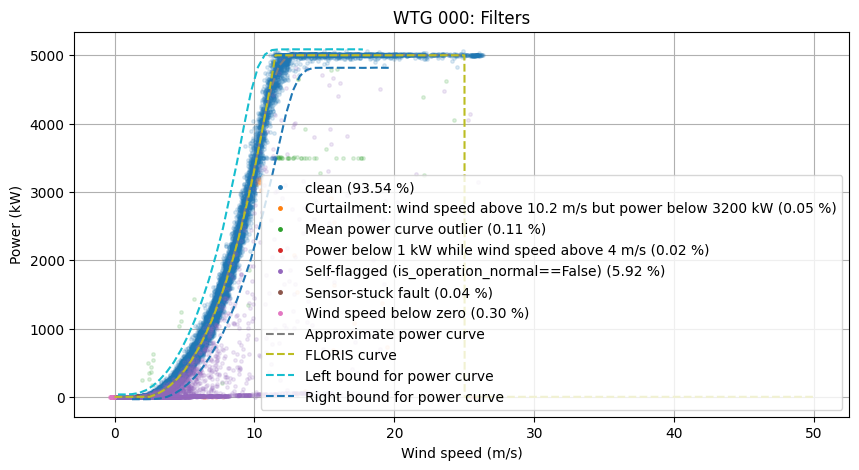

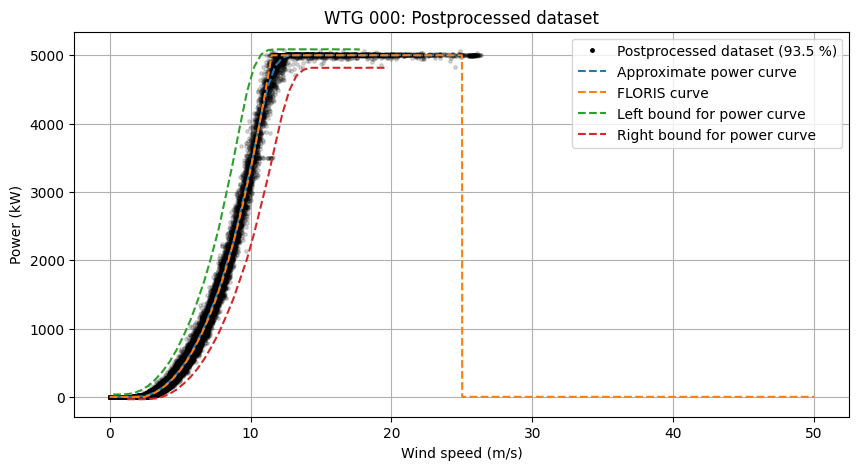

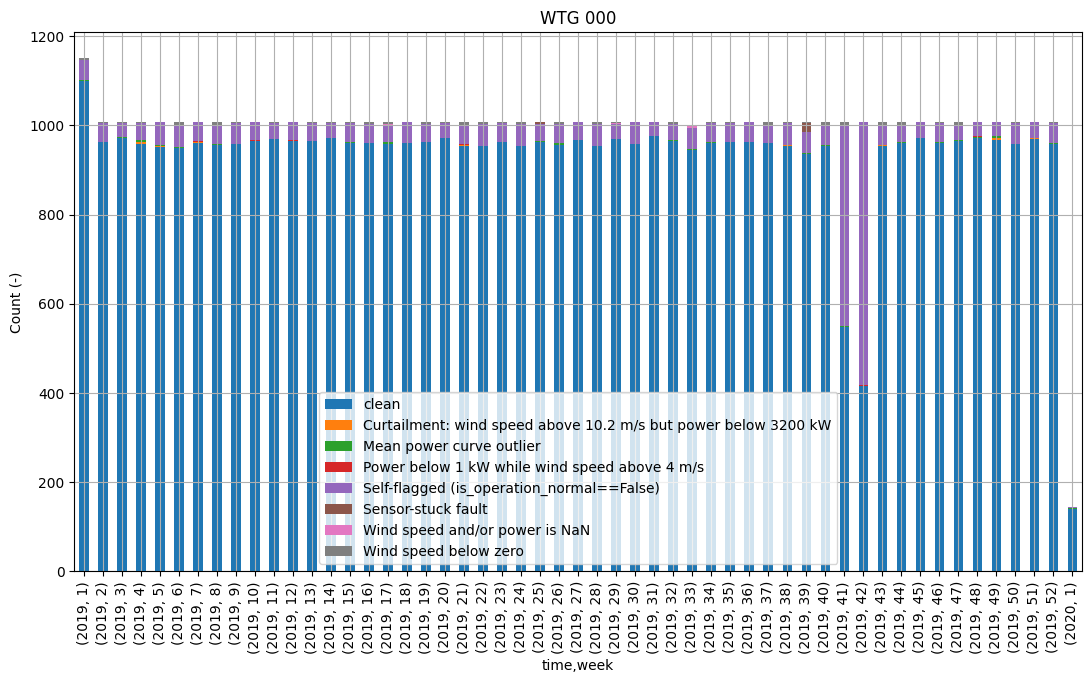

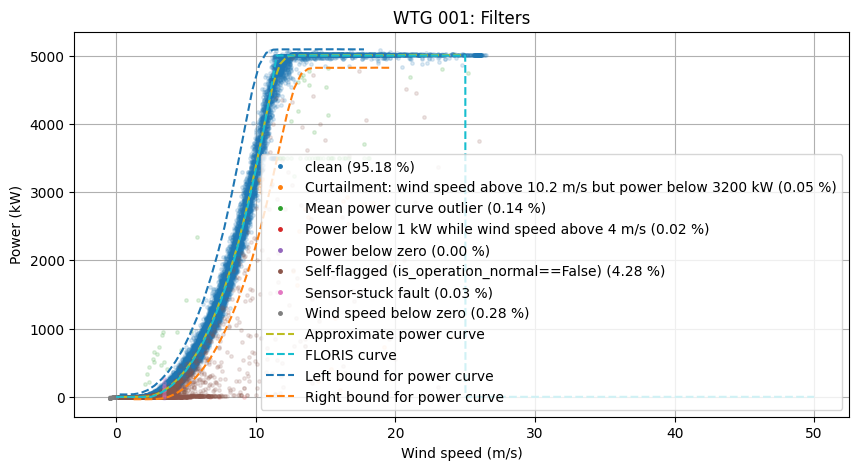

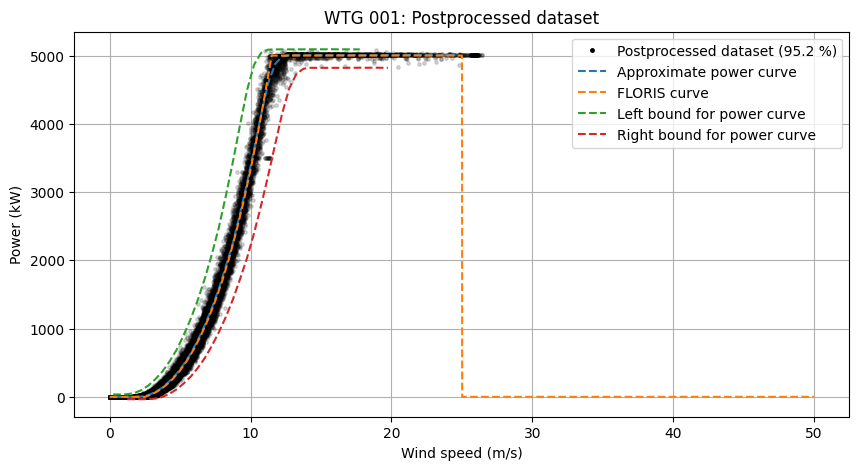

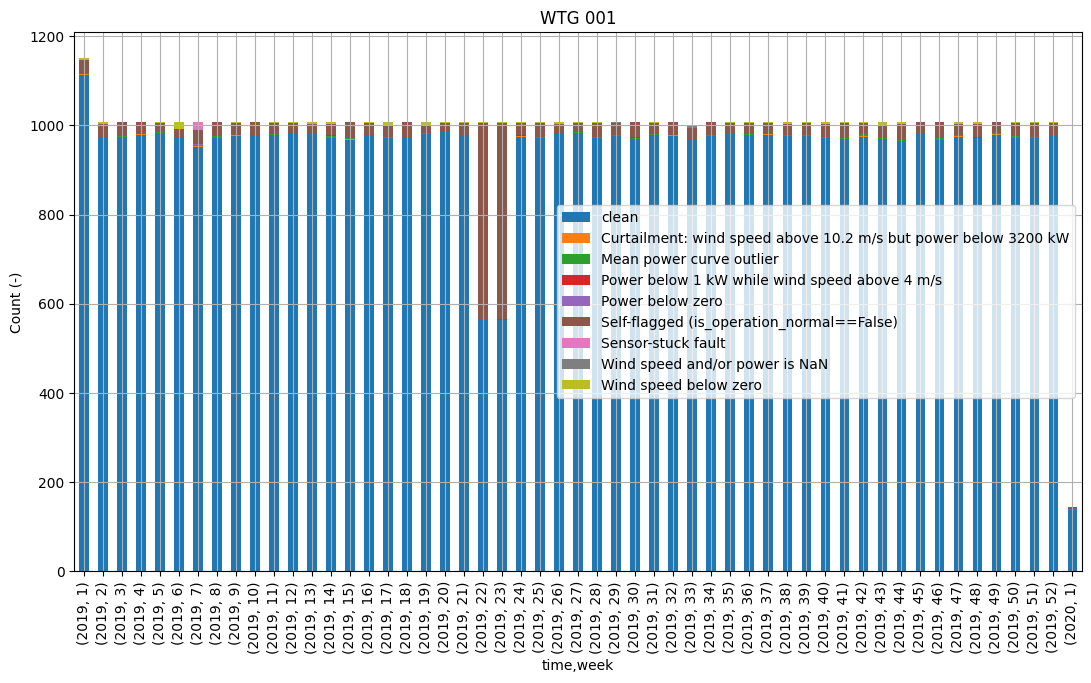

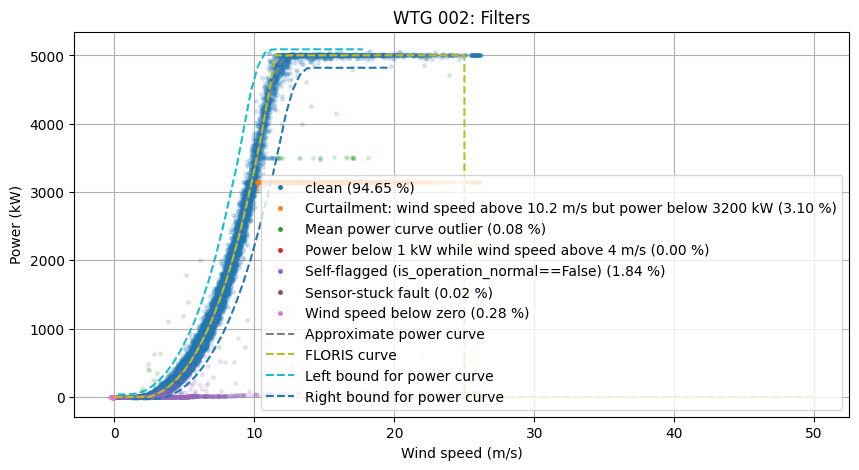

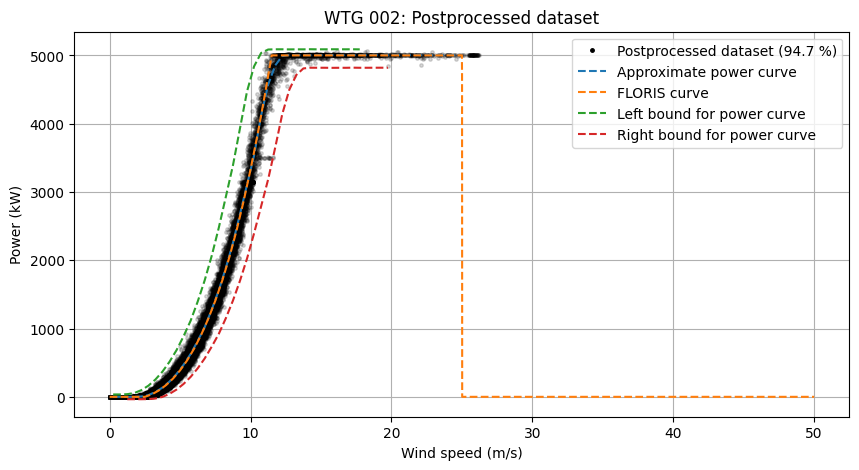

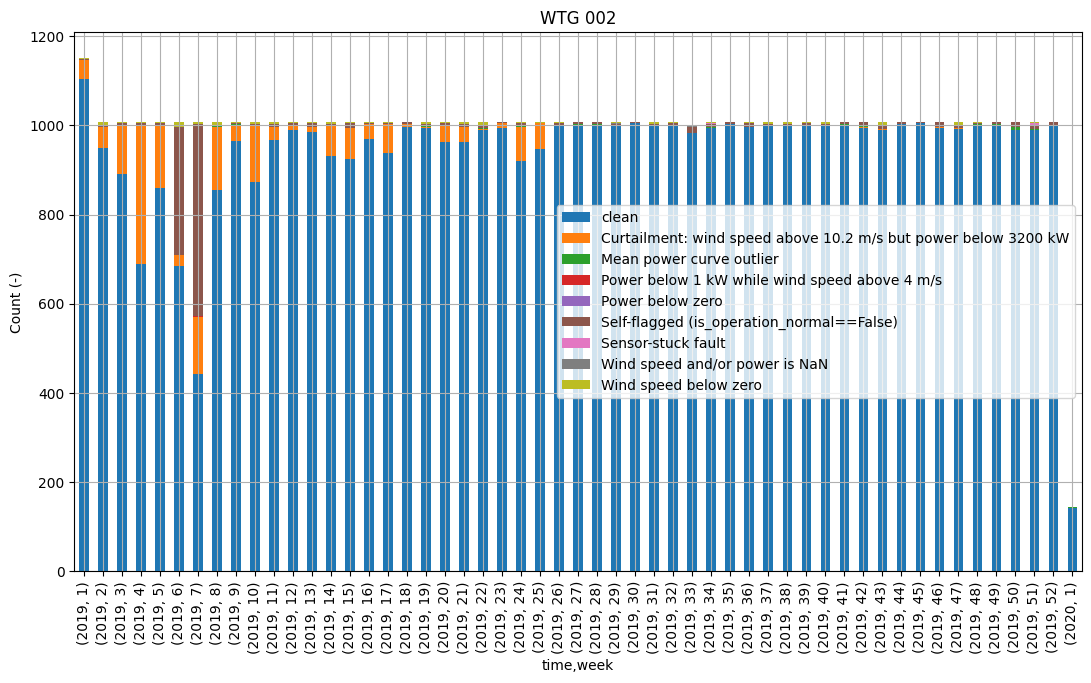

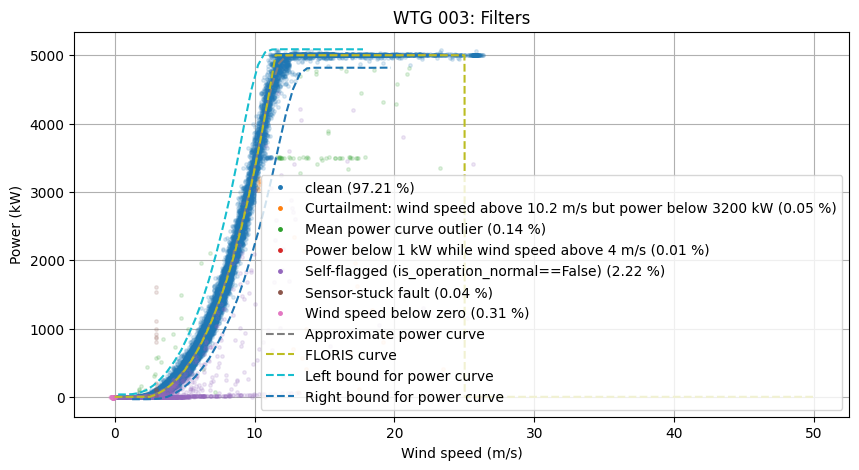

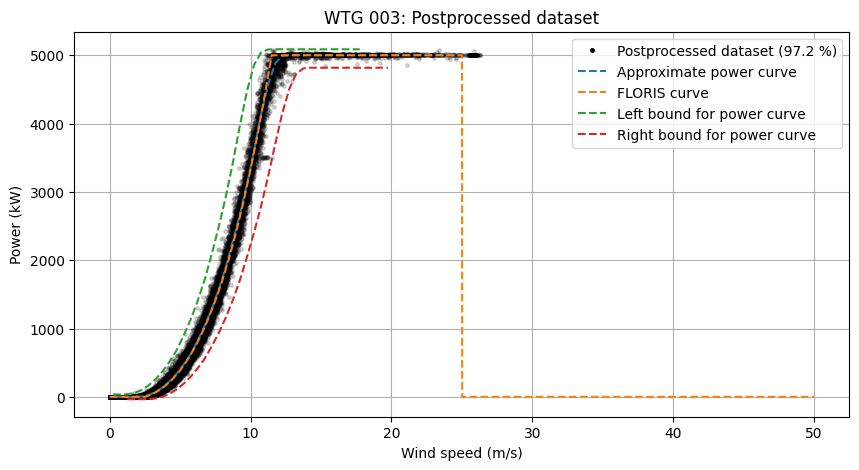

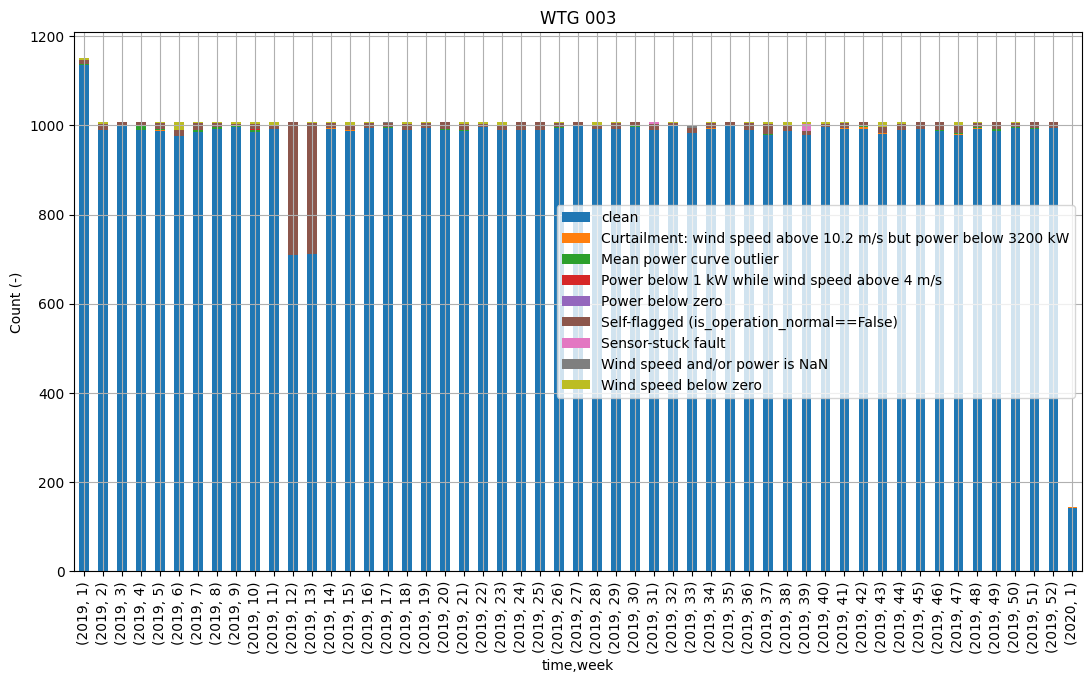

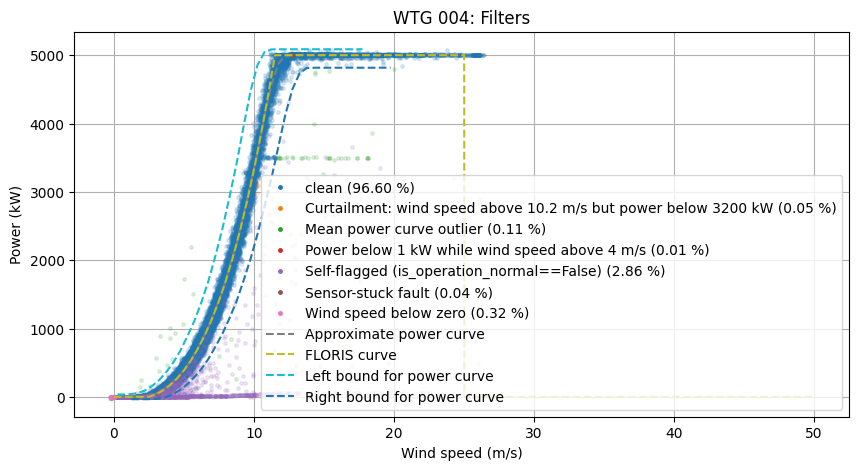

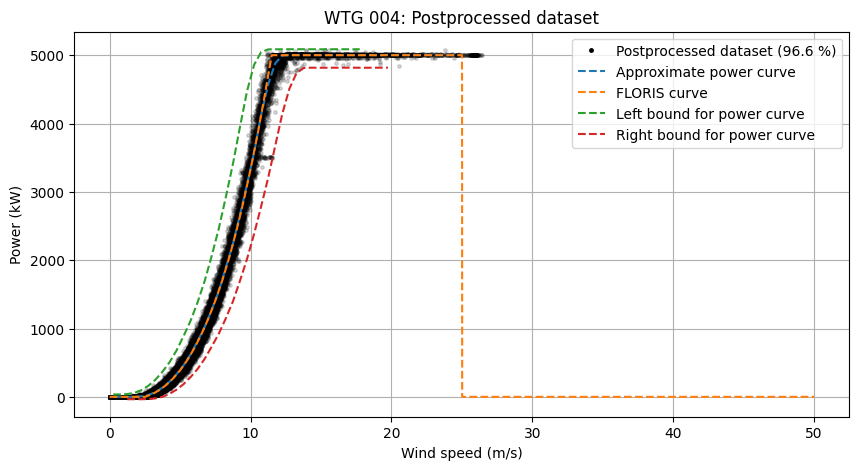

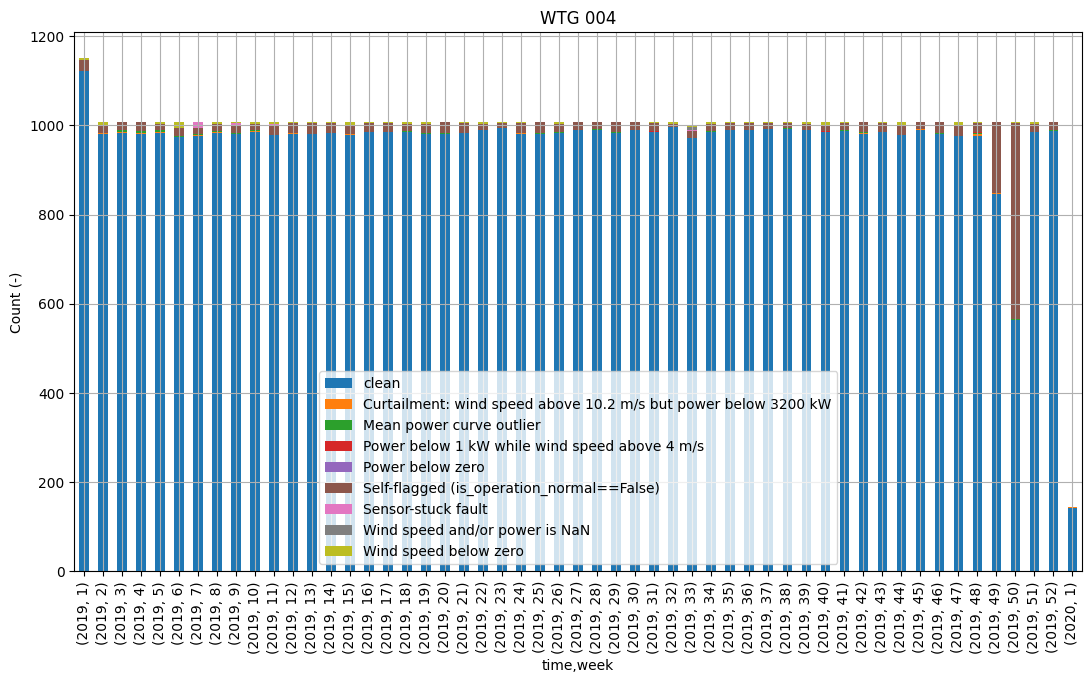

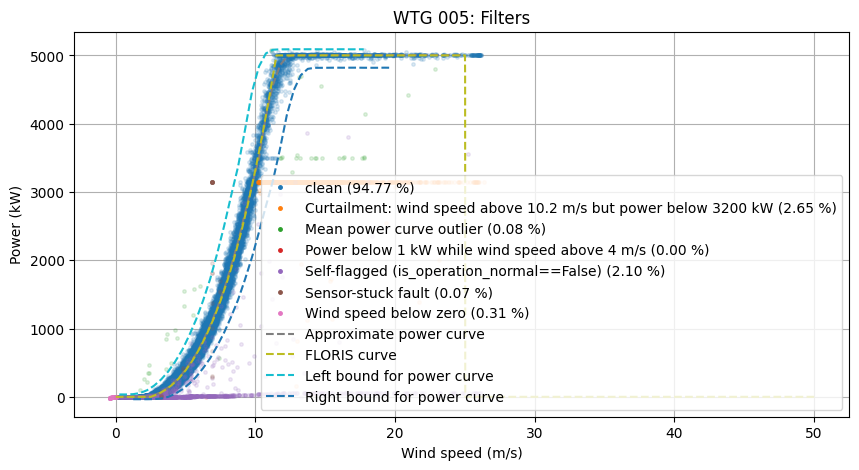

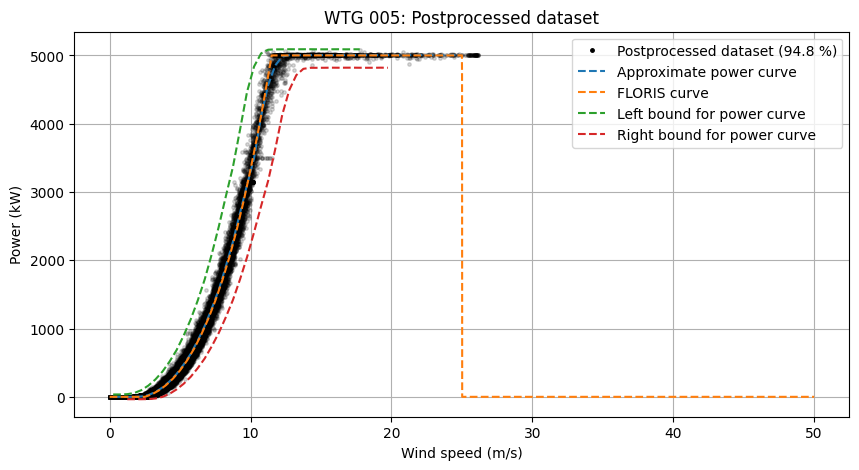

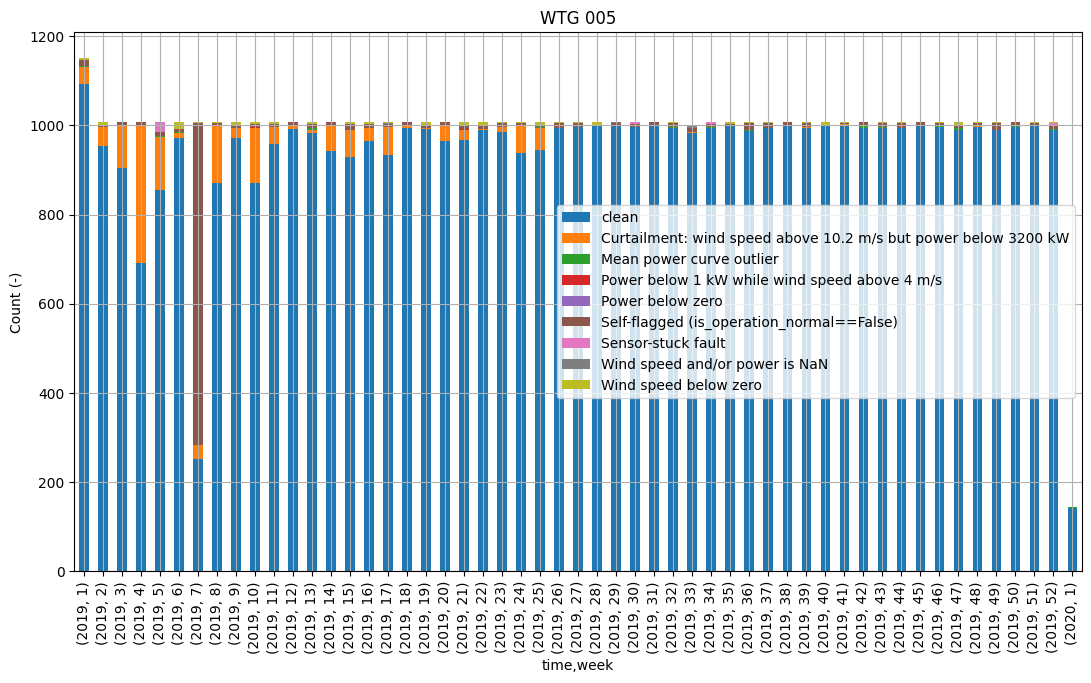

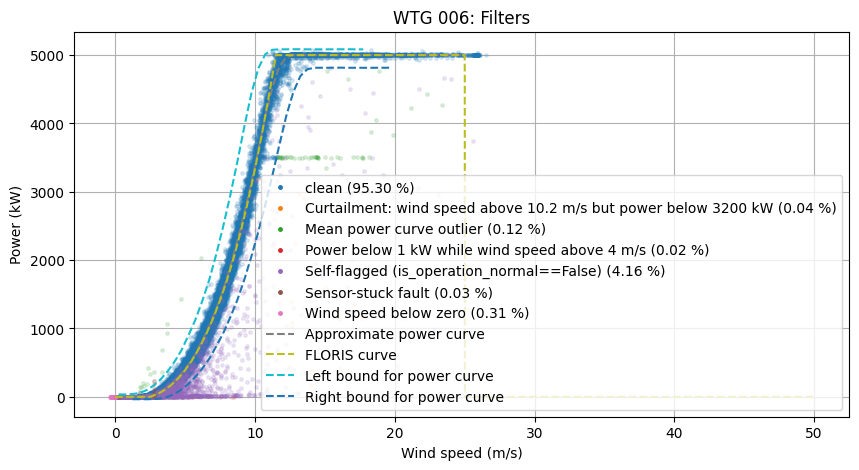

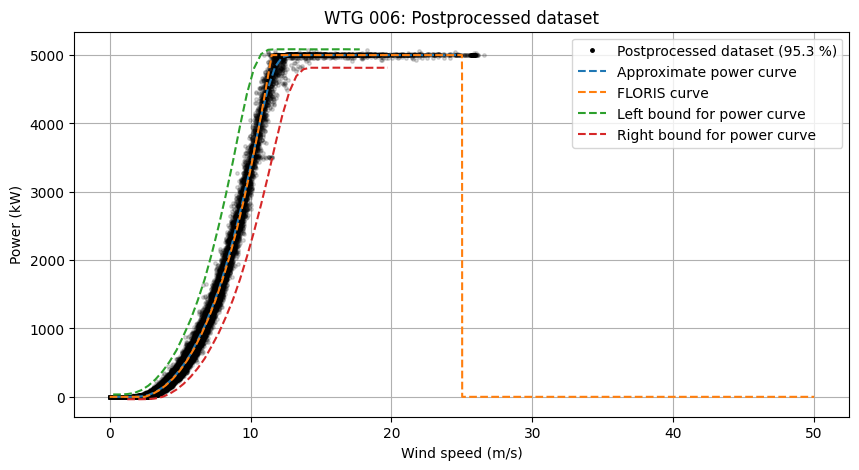

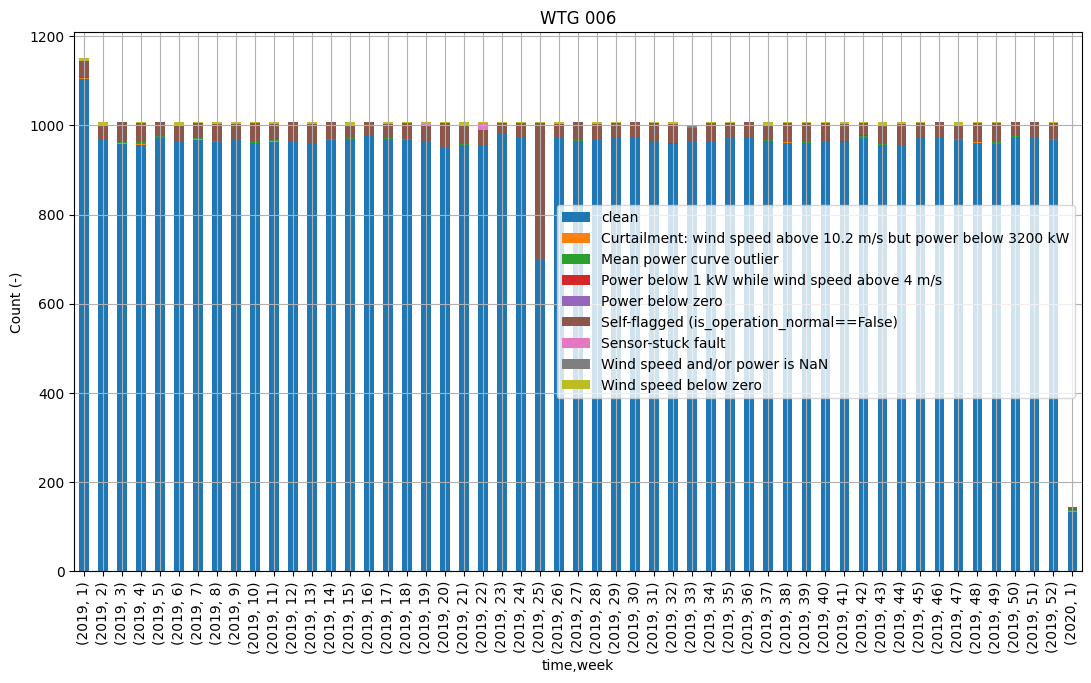

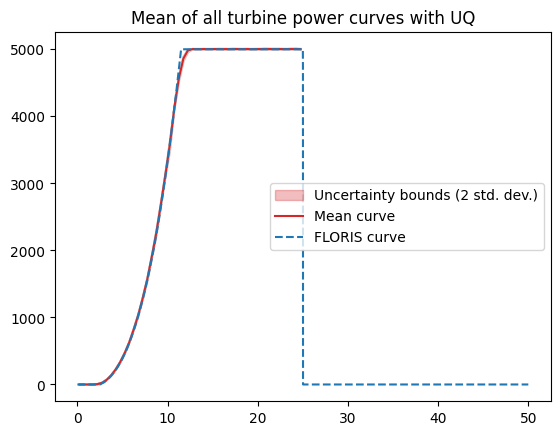

In [5]:
# # **Step 4**: Deal with wind-speed power curve filtering
def filter_by_ws_pow_curve(df, plot_figures=True, save_figures=False, use_bokeh_for_plots=False):
    # Load the FLORIS model for the wind farm. This is not used for anything
    # besides plotting the floris-predicted wind speed-power curve on top
    # of the actual data.
    fi, _ = load_floris()

    # Downsample data. Not necessary here, but can be useful if we have 1 Hz
    # data available. Namely, it's hard to detect outliers on such a high
    # resolution. Instead, we are better off downsampling the data to 60s or
    # even 600s and filter the data based on decisions there. The following
    # downsampled dataframe should then be inserted into the wind speed power
    # curve filtering class. Mapping the filtering back to the high-resolution
    # data is done by a couple lines of code as found at the end of this
    # script.
    #
    # df_movavg, data_indices_mapping = top.df_movingaverage(
    #     df_in=df_1s,
    #     cols_angular=[
    #         c for c in df_1s.columns if (
    #             ("vane_" in c) or
    #             ("yaw_" in c) or
    #             ("wd_" in c) or
    #             ("direction" in c)
    #         )
    #     ],
    #     window_width=td(seconds=600),
    #     calc_median_min_max_std=False,
    #     return_index_mapping=True,
    # )

    # Create output directory
    if plot_figures:
        if save_figures:
            root_path = os.getcwd()
            figure_save_path = os.path.join(root_path, "postprocessed", "figures")
            os.makedirs(figure_save_path, exist_ok=True)
        else:
            if use_bokeh_for_plots:
                # Produce Bokeh figures directly to notebook
                output_notebook()

    # Initialize the wind speed power curve filtering class
    ws_pow_filtering = wspf.ws_pw_curve_filtering(df=df)

    # Apply a set of logic filters on the turbine measurements
    n_turbines = dfm.get_num_turbines(df)
    for ti in range(n_turbines):
        # Filter for NaN wind speed or power productions
        ws_pow_filtering.filter_by_condition(
            condition=(
            ws_pow_filtering.df["ws_{:03d}".format(ti)].isna() |
            ws_pow_filtering.df["pow_{:03d}".format(ti)].isna()
            ),
            label="Wind speed and/or power is NaN",
            ti=ti,
            verbose=True,
        )

        # Filter for numerical issues
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["ws_{:03d}".format(ti)] < -1.0e-6),
            label="Wind speed below zero",
            ti=ti,
            verbose=True,
        )

        # Filter for numerical issues
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["pow_{:03d}".format(ti)] < -1.0e-6),
            label="Power below zero",
            ti=ti,
            verbose=True,
        )

        # Filter for numerical issues
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["ws_{:03d}".format(ti)] > 50),
            label="Wind speed above 50 m/s",
            ti=ti,
            verbose=True,
        )

        # Filter for numerical issues: note, make sure power is in kW
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["pow_{:03d}".format(ti)] > 30e3),
            label="Power above 30 MW",
            ti=ti,
            verbose=True,
        )

        # Filter for power production is zero above cut-in wind speeds
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["ws_{:03d}".format(ti)] > 4.0) & (ws_pow_filtering.df["pow_{:03d}".format(ti)] < 1.0),
            label="Power below 1 kW while wind speed above 4 m/s",
            ti=ti,
            verbose=True,
        )

        # Other common filters here are based on turbine-specific/OEM-specific flags. For example,
        # a 'run counter' may indicate how many seconds of a 10-minute period the turbine was
        # reporting valid measurements. By filtering for the condition that that value is 600, or
        # above 590, you should be able to quickly identify a large part of faulty measurements.
        # Similarly, you may want to look for 'turbineOK' and 'normal_operation' flag of the
        # turbine.
        #
        # Additionally, if you have blade pitch angle measurements, you may be able to filter
        # for outliers by looking when blade pitch angles exceed, e.g., 70 degrees. These filter
        # steps very much depend on the dataset that you have access to. 
        # 
        # Another useful variable is 'power setpoint', if that is available. You can use this
        # to detect and then filter for turbine curtailment (i.e., turbine setpoint lower
        # than available power on purpose). Same thing goes for derating codes, signifying
        # particular derating/curtailment behavior, power mode signals, alarm signals.
        #
        # In this case, we have an operational_status flag. If that has a 'False' value, then we
        # mark those measurements as faulty.
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["is_operation_normal_{:03d}".format(ti)] == False),
            label="Self-flagged (is_operation_normal==False)",
            ti=ti,
            verbose=True,
        )

        # Filter for sensor-stuck faults
        ws_pow_filtering.filter_by_sensor_stuck_faults(
            columns=["wd_{:03d}".format(ti), "ws_{:03d}".format(ti)],
            ti=ti,
            n_consecutive_measurements=3,
            stddev_threshold=0.001,
            plot=False,
        )

        # Flag curtailment by marking measurements with a high wind speed but
        # lower power production as faulty.
        ws_pow_filtering.filter_by_condition(
            condition=(
                (ws_pow_filtering.df["ws_{:03d}".format(ti)] > 10.2) &
                (ws_pow_filtering.df["pow_{:03d}".format(ti)] < 3200.0)
            ),
            label="Curtailment: wind speed above 10.2 m/s but power below 3200 kW",
            ti=ti,
            verbose=True,
        )

        # Now filter iteratively by deviations from the median power curve.
        # Common reason for measurements with a low wind speed but a high power
        # production (i.e., to the left of the mean curve) is icing or dirt on the
        # wind speed sensor, or generally a the wind speed sensor being obstructed
        # in some way.
        ws_pow_filtering.filter_by_power_curve(
            ti=ti,
            ws_deadband=1.5,
            pow_deadband=70.0,
            cutoff_ws=20.0,
            m_pow_rb=0.97,
        )

        # An additional filtering step we may consider here is removing all measurements
        # directly after a NaN. The reasoning behind this is that the wind farm flow
        # may still be affected by an outlier/odd turbine behavior the 10 minutes
        # after that problem was solved, due to wake propagation delays.
        # Note that this doubles the number of NaNs in your dataset and thereby decreases
        # the useful data pool. In this example, we decide not to filter for that.

        if plot_figures:
            # If true, uses Bokeh for plotting library. Benefits are that it can save
            # figures as an interactive .html file, for future exploring.
            if use_bokeh_for_plots:
                p_ws_pow = ws_pow_filtering.plot_filters_custom_scatter_bokeh(
                    x_col=f"ws_{ti:03d}",
                    y_col=f"pow_{ti:03d}",
                    title=f"Wind speed power curve of WTG {ti:03d}",
                    xlabel="Wind speed (m/s)",
                    ylabel="Power production (kW)",
                    ti=ti,
                )

                if save_figures:
                    fout = os.path.join(figure_save_path, f"ws_power_{ti:03d}.html")
                    output_file(fout)
                    save(p_ws_pow)
                    print(f"Interactive figure saved to '{os.path.relpath(fout):s}'.")
                else:
                    show(p_ws_pow)

                ax = ws_pow_filtering.plot_postprocessed_in_ws_power_curve(ti=ti, fi=fi)
                if save_figures:
                    plt.savefig(os.path.join(figure_save_path, f"ws_pow_postprocessed_{ti:03d}.png"))

                p_filters_time = ws_pow_filtering.plot_filters_in_time_bokeh(ti=ti)
                if save_figures:
                    fout = os.path.join(figure_save_path, f"filters_over_time_{ti:03d}.html")
                    output_file(fout)
                    save(p_filters_time)
                    print(f"Interactive figure saved to '{os.path.relpath(fout):s}'.")
                else:
                    show(p_filters_time)

                # # Plot and save pitch measurements [not available in example dataset]
                # p_ws_pitch = ws_pow_filtering.plot_filters_custom_scatter_bokeh(
                #     x_col=f"ws_{ti:03d}",
                #     y_col=f"blade_pitch_{ti:03d}",
                #     xlabel="Wind speed (m/s)",
                #     ylabel="Blade pitch angle (deg)",
                #     title=f"Wind speed vs blade pitch angle for WTG {ti:03d}",
                #     ti=ti,
                # )

                # if save_figures:
                #     fout = os.path.join(figure_save_path, f"ws_pitch_{ti:03d}.html")
                #     output_file(fout)
                #     save(p_ws_pitch)
                #     print(f"Interactive figure saved to '{os.path.relpath(fout):s}'.")
                # else:
                #     show(p_ws_pitch)

            else:
                # Plot and save data for current dataframe
                ax = ws_pow_filtering.plot_filters_in_ws_power_curve(ti=ti, fi=fi)
                if save_figures:
                    plt.savefig(os.path.join(figure_save_path, f"ws_pow_{ti:03d}.png"))

                ax = ws_pow_filtering.plot_postprocessed_in_ws_power_curve(ti=ti, fi=fi)
                if save_figures:
                    plt.savefig(os.path.join(figure_save_path, f"ws_pow_postprocessed_{ti:03d}.png"))

                ax = ws_pow_filtering.plot_filters_in_time(ti=ti)
                if save_figures:
                    plt.savefig(os.path.join(figure_save_path, f"filters_over_time_{ti:03d}.png"))

        print("\n")

    if plot_figures:
        # Plot farm-averaged power curve based on the data (useful to e.g., feed into FLORIS when not provided by OEM)
        fig, ax = ws_pow_filtering.plot_farm_mean_power_curve(fi=fi)
        if save_figures:
            plt.savefig(os.path.join(figure_save_path, "median_farm_power_curves.png"))

    # Get filtered dataframe and power curve
    df = ws_pow_filtering.get_df()
    df_pow_curve = ws_pow_filtering.pw_curve_df

    return df, df_pow_curve

df_scada_filtered, df_pow_curve = filter_by_ws_pow_curve(
    df=df_scada_formatted.copy(),
    plot_figures=plot_figures,
    save_figures=save_figures,
    use_bokeh_for_plots=use_bokeh_plotting_library
)

# **Step 3**: Plot faults vs. the layout

Saving figure to /Users/msinner/flasc/examples_artificial_data/01_raw_data_processing/postprocessed/figures/faults_by_layout.png.


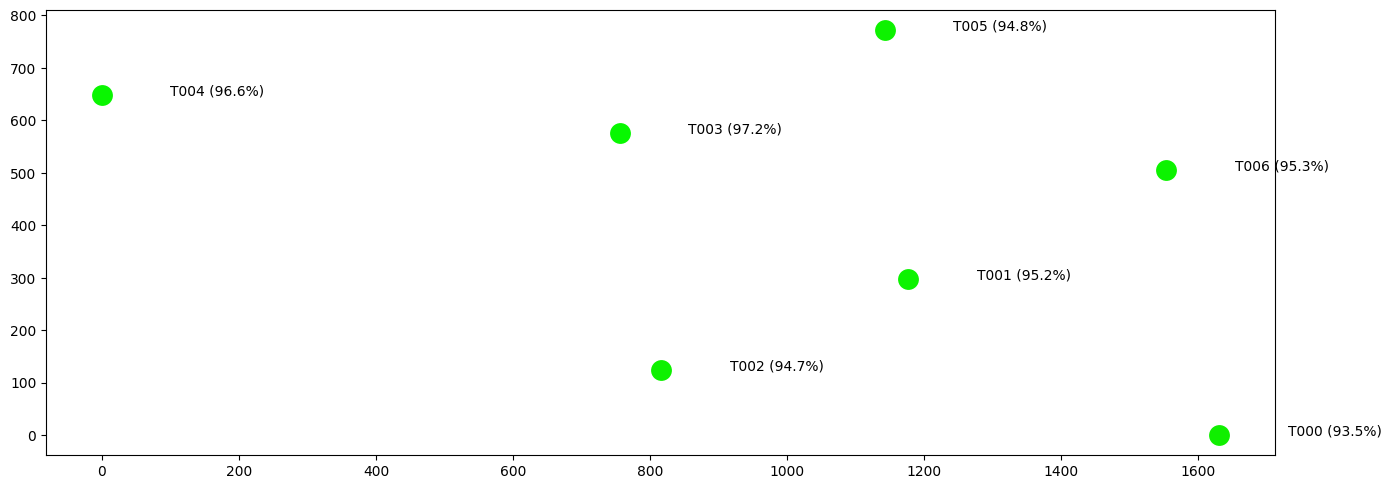

In [6]:
def plot_faults_vs_layout(df):
    fi, turbine_weights = load_floris()

    layout_x = fi.layout_x
    layout_y = fi.layout_y

    num_turbines = dfm.get_num_turbines(df)
    fault_ratio = np.zeros(num_turbines)
    for ti in range(num_turbines):
        fault_ratio[ti] = (
            dff.df_get_no_faulty_measurements(df, ti) / df.shape[0]
        )

    # Plot layout and colormap
    fig, ax = plt.subplots(figsize=(14, 5))
    for ti in range(num_turbines):
        clr = [fault_ratio[ti], 1.0 - fault_ratio[ti], 0.0]
        ax.plot(
            layout_x[ti],
            layout_y[ti],
            "o",
            markersize=15,
            markerfacecolor=clr,
            markeredgewidth=0.0,
        )
        ax.text(
            layout_x[ti] + 100,
            layout_y[ti],
            "T%03d (%.1f%%)" % (ti, (1.0 - fault_ratio[ti]) * 100.0),
            color="black",
        )
    fig.tight_layout()

    root_path = os.getcwd()
    out_path = os.path.join(root_path, "postprocessed", "figures")
    fig_out = os.path.join(out_path, "faults_by_layout.png")
    print("Saving figure to {:s}.".format(fig_out))
    os.makedirs(out_path, exist_ok=True)
    plt.savefig(fig_out, dpi=300)

plot_faults_vs_layout(df_scada_filtered)

# **Save postprocessed data** to a local file

In [7]:
root_path = os.getcwd()
fout = os.path.join(root_path, "postprocessed", "df_scada_600s_wspowfiltered.ftr")
df_scada_filtered.to_feather(fout)
print("File saved to '{:s}'.".format(os.path.relpath(fout)))

File saved to 'postprocessed/df_scada_600s_wspowfiltered.ftr'.


In [8]:
# Print all (remaining) figures
plt.show()